In [16]:
import pandas as pd
import numpy as np
import os

code = '159937'
date = '2025-08-21'
lob_file = fr"D:\L2_DATA_T0_ETF\his_data\{date.replace('-', '')}\{code}\十档盘口.csv"

In [6]:
def fix_raw_data(date, code):
    """
    数据预处理
    """
    am_begin_t = os.environ.get('am_begin_time', '09:30')
    am_end_t = os.environ.get('am_end_time', '11:30')
    pm_begin_t = os.environ.get('pm_begin_time', '13:00')
    pm_end_t = os.environ.get('pm_end_time', '14:45')

    if os.path.exists(lob_file):
        _data = pd.read_csv(lob_file, encoding='gbk')

        # 删除完全重复的行
        _data = _data.drop_duplicates(keep='first')

        # 格式化 时间
        _data['时间'] = pd.to_datetime(_data['时间'])
        # 截取 10:00 - 14:30
        _data = _data[(_data["时间"].dt.time >= pd.to_datetime(am_begin_t).time()) & (
            _data["时间"].dt.time < pd.to_datetime(pm_end_t).time())].reset_index(drop=True)
        _data = _data[(_data["时间"].dt.time <= pd.to_datetime(am_end_t).time()) | (
            _data["时间"].dt.time > pd.to_datetime(pm_begin_t).time())].reset_index(drop=True)
        if len(_data) == 0:
            print(f'fix_raw_data: {date} {code} 没有数据')
            return

        # 涨停判断：卖1-卖10 的价格或挂单量 全为0
        sell_price_cols = [f'卖{i}价' for i in range(1, 11)]  # 卖1价 ~ 卖10价
        sell_volume_cols = [f'卖{i}量' for i in range(1, 11)]  # 卖1量 ~ 卖10量
        zt = (_data[sell_price_cols].eq(0).all(axis=1)) & (_data[sell_volume_cols].eq(0).all(axis=1))
        # 跌停判断：买1-买10 的价格或挂单量 全为0
        buy_price_cols = [f'买{i}价' for i in range(1, 11)]   # 买1价 ~ 买10价
        buy_volume_cols = [f'买{i}量' for i in range(1, 11)]   # 买1量 ~ 买10量
        dt = (_data[buy_price_cols].eq(0).all(axis=1)) & (_data[buy_volume_cols].eq(0).all(axis=1))
        if zt.any() or dt.any():
            print(f'fix_raw_data: {date} {code} 存在涨跌停')
            return
        
        # 处理异常的没有价/量
        # 这个档位挂单为0（但没及时的清除）
        # 处理: 使用第二个档位价格的偏移，量为1
        miss_ask = (_data['卖1价'] == 0) & (_data['卖1量'] == 0)
        if miss_ask.any():
            print(f'修复卖1数据: {date} {code} 存在无价无量')
            assert (_data.loc[miss_ask, '卖2价'] - 0.001 != _data.loc[miss_ask, '买1价']).all(), '处理缺失 ask 档位价格异常'
            _data.loc[miss_ask, '卖1价'] = _data.loc[miss_ask, '卖2价'] - 0.001
            _data.loc[miss_ask, '卖1量'] = 1
        miss_bid = (_data['买1价'] == 0) & (_data['买1量'] == 0)
        if miss_bid.any():
            print(f'修复买1数据: {date} {code} 存在无价无量')
            assert (_data.loc[miss_bid, '买2价'] + 0.001 != _data.loc[miss_bid, '卖1价']).all(), '处理缺失 bid 档位价格异常'
            _data.loc[miss_bid, '买1价'] = _data.loc[miss_bid, '买2价'] + 0.001
            _data.loc[miss_bid, '买1量'] = 1

        _data = _data.reset_index(drop=True)

        # 删除列 '卖1价' 和 '买1价' 中存在 NaN 值的行
        # _data = _data.dropna(subset=['卖1价', '买1价']).reset_index(drop=True)
        # 暂时不允许 '卖1价', '买1价' 存在 NaN
        msg = ''
        if _data['卖1价'].isna().any():
            msg += f'{date} {code} 卖1价存在 NaN\n'
        if (_data['卖1价'] == 0).any():
            msg += f'{date} {code} 卖1价存在 0\n'
        if _data['买1价'].isna().any():
            msg += f'{date} {code} 买1价存在 NaN\n'
        if (_data['买1价'] == 0).any():
            msg += f'{date} {code} 买1价存在 0\n'
        if msg:
            raise Exception(msg)

        # 可以容忍的异常值处理
        # 2-10 档位价格nan填充, 使用上一个档位数据 +-0.001 进行填充
        for i in range(2, 11):
            # 买价
            _data.loc[:, f'买{i}价'] = _data[f'买{i}价'].fillna(_data[f'买{i-1}价'] - 0.001)
            # 卖价
            _data.loc[:, f'卖{i}价'] = _data[f'卖{i}价'].fillna(_data[f'卖{i-1}价'] + 0.001)
        
        # 盘口量nan与0都用1填充
        vol_cols = [i for i in list(_data) if '量' in i]
        _data[vol_cols] = _data[vol_cols].replace(0, np.nan).fillna(1)

        # 格式化 总卖 总买
        for col in ['总卖', '总买']:
            try:
                _data[col] = _data[col].astype(float)
            except:
                _data[col] = _data[col].apply(
                    lambda x: 10000 * (float(x.replace("万", "")))
                    if "万" in str(x)
                    else 1e8 * (float(x.replace("亿", "")))
                    if "亿" in str(x)
                    else float(x)
                )

        return _data

    else:
        print(f'{date} {code} 没有数据, {lob_file} 不存在')


In [18]:
data = fix_raw_data(date, code)
data['时间'] = pd.to_datetime(data['时间'])
data = data.set_index('时间')
data['mid'] = (data['买1价'] + data['卖1价']) / 2
data = data.loc[f'{date} 10:00':f'{date} 14:30', ['mid', '买1价', '卖1价']]
data = data.reset_index(drop=True)
data

,mid,买1价,卖1价
0,7.3905,7.390,7.391
1,7.3905,7.390,7.391
2,7.3905,7.390,7.391
3,7.3905,7.390,7.391
4,7.3905,7.390,7.391
...,...,...,...
3042,7.3755,7.375,7.376
3043,7.3755,7.375,7.376
3044,7.3755,7.375,7.376
3045,7.3755,7.375,7.376


<Axes: >

d:\programs\miniconda3\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20080 (\N{CJK UNIFIED IDEOGRAPH-4E70}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\programs\miniconda3\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\programs\miniconda3\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 21334 (\N{CJK UNIFIED IDEOGRAPH-5356}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
d:\programs\miniconda3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20080 (\N{CJK UNIFIED IDEOGRAPH-4E70}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\programs\miniconda3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\programs\miniconda3\lib\site-pa

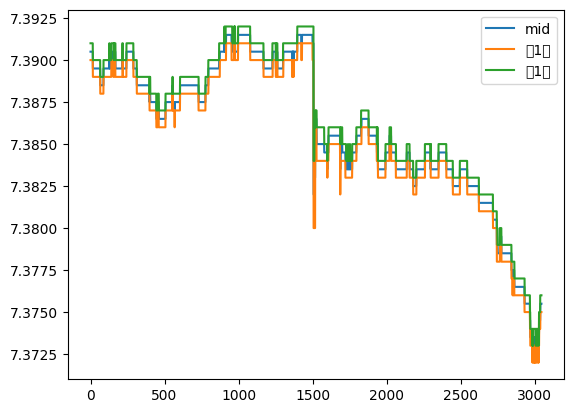

In [19]:
data.plot()